In [ ]:
# Java kurulumu (Spark için gereklidir)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Spark 3.4.1 + Hadoop 3 kurulumu (güncel ve çalışan bağlantı)
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz

# Spark ile Python'u entegre etmek için findspark kurulumu
!pip install -q findspark



In [ ]:
import os
import findspark

# Spark ve Java dizinlerini tanımla
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# Spark başlatılsın
findspark.init()

from pyspark.sql import SparkSession

# Spark oturumu oluştur (artık büyük veriyi işleyebiliriz!)
spark = SparkSession.builder \
    .appName("DiyabetTahminiProjesi") \
    .getOrCreate()

# Spark çalışıyor mu test edelim
spark


In [ ]:
# Spark ile CSV verisini oku
df = spark.read.csv("/content/diabetes.csv", header=True, inferSchema=True)

# İlk birkaç satırı göster
df.show(5)

# Veri tiplerini ve sütunları gör
df.printSchema()


+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nul

In [ ]:
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

In [ ]:
from pyspark.sql.functions import col

# 0 içeren şüpheli sütunlarda kaç adet 0 var?
for column in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]:
    zero_count = df.filter(col(column) == 0).count()
    print(f"{column} sütununda 0 olan satır sayısı: {zero_count}")


Glucose sütununda 0 olan satır sayısı: 5
BloodPressure sütununda 0 olan satır sayısı: 35
SkinThickness sütununda 0 olan satır sayısı: 227
Insulin sütununda 0 olan satır sayısı: 374
BMI sütununda 0 olan satır sayısı: 11


In [ ]:
from pyspark.sql.functions import when, avg

# Ortalama hesapla
means = df.select(
    *[avg(col(c)).alias(c) for c in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]]
).collect()[0].asDict()

# 0 değerlerini ortalama ile doldur
for c in means:
    df = df.withColumn(c, when(col(c) == 0, means[c]).otherwise(col(c)))


In [ ]:
# Pandas, matplotlib ve seaborn kütüphanelerini yükle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Spark DataFrame -> Pandas DataFrame dönüşümü
pdf = df.toPandas()

# Grafiklerin düzgün görünmesi için
plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)


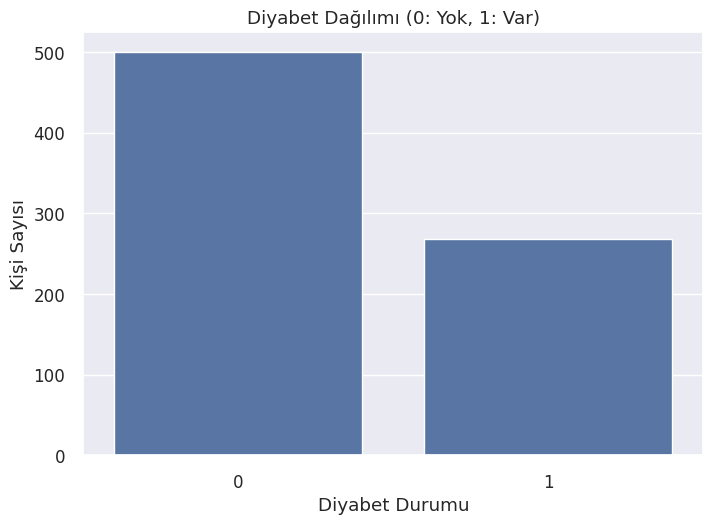

In [ ]:
# Kaç kişi diyabet hastası? (1) Kaç kişi değil? (0)
sns.countplot(x='Outcome', data=pdf)
plt.title("Diyabet Dağılımı (0: Yok, 1: Var)")
plt.xlabel("Diyabet Durumu")
plt.ylabel("Kişi Sayısı")
plt.show()


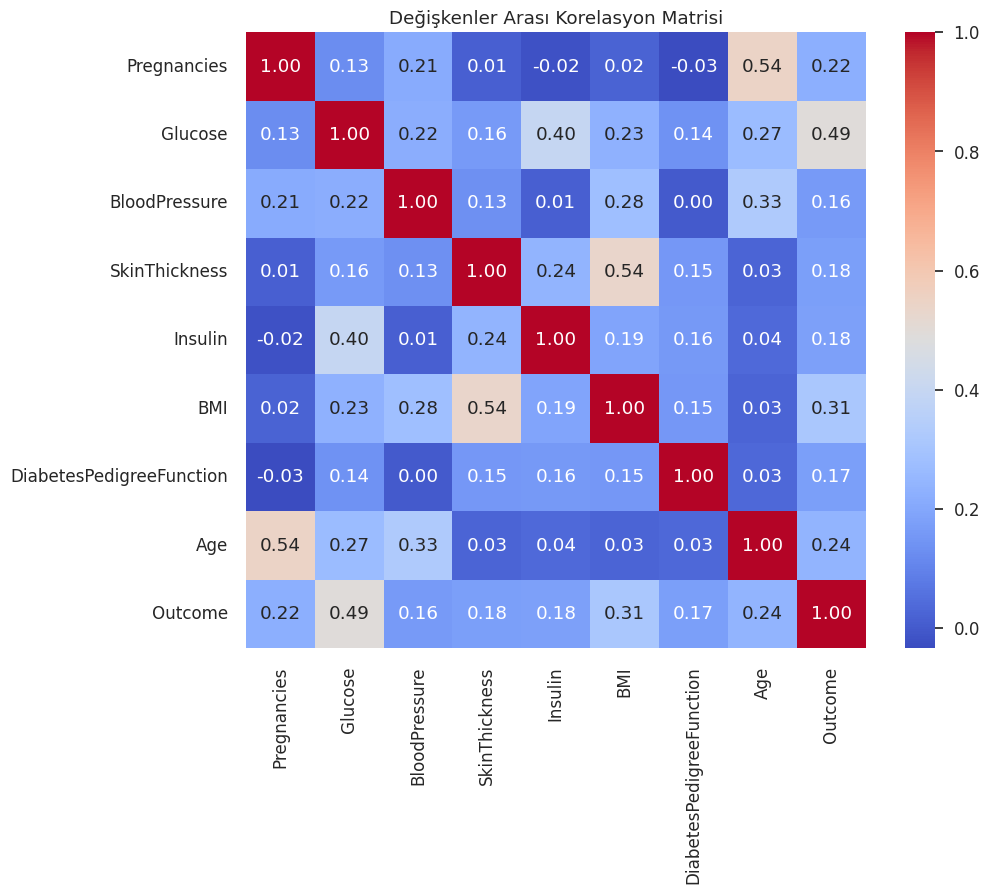

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(pdf.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Değişkenler Arası Korelasyon Matrisi")
plt.show()


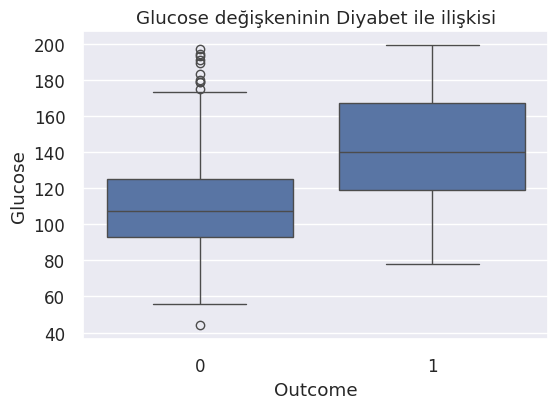

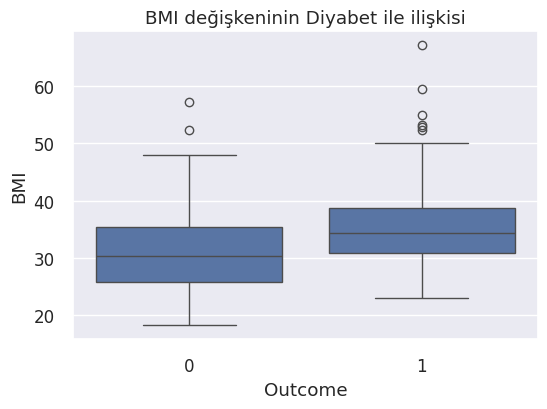

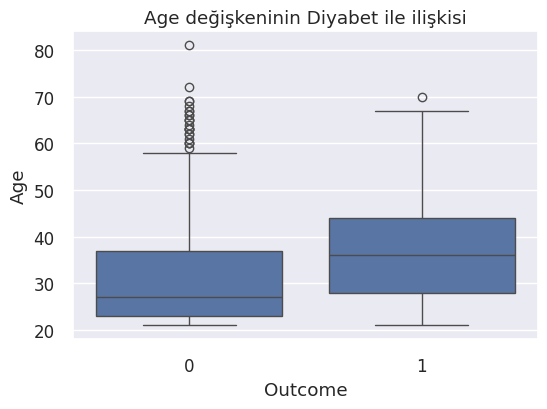

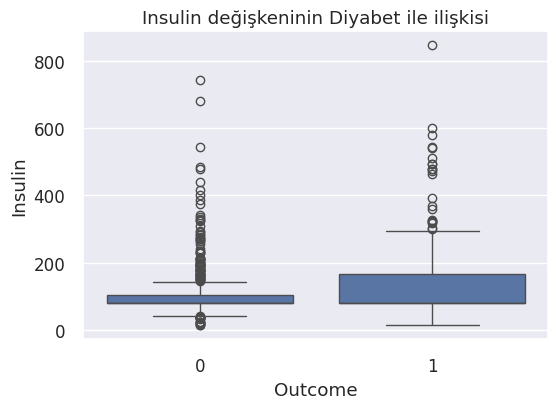

In [ ]:
# Glikoz ve BMI gibi değişkenlerin dağılımı
features = ["Glucose", "BMI", "Age", "Insulin"]

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Outcome', y=feature, data=pdf)
    plt.title(f"{feature} değişkeninin Diyabet ile ilişkisi")
    plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline


In [ ]:
# Modelde kullanacağımız giriş değişkenleri
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                   'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Spark modellemelerinde tüm feature'lar tek bir vektöre çevrilmelidir
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Dönüştürülmüş veri
df_ml = assembler.transform(df)

In [ ]:
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)


In [ ]:
lr = LogisticRegression(featuresCol="features", labelCol="Outcome")
lr_model = lr.fit(train_data)


In [ ]:
predictions = lr_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="Outcome", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC-AUC Skoru: {roc_auc:.4f}")


ROC-AUC Skoru: 0.8584


In [ ]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Pandas'a düzgün dönüşüm
y_true = predictions.select("Outcome").rdd.map(lambda row: row[0]).collect()
y_pred = predictions.select("prediction").rdd.map(lambda row: row[0]).collect()

# Metrikleri hesapla
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# Yazdır
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)


Accuracy  : 0.7886
Precision : 0.7879
Recall    : 0.5778
F1 Score  : 0.6667

Confusion Matrix:
[[71  7]
 [19 26]]
